In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

x_train = pd.read_csv('data/features_scaled.csv').drop('Unnamed: 0', axis=1)
x_train_pca = pd.read_csv('data/train_PCA.csv').drop('Unnamed: 0', axis=1)

x_test = pd.read_csv('data/test_data_scaled.csv').drop('Unnamed: 0', axis=1)
x_test_pca = pd.read_csv('data/test_PCA.csv').drop('Unnamed: 0', axis=1)

y = pd.read_csv('data/target_scaled.csv').drop('Unnamed: 0', axis=1)
y_dist = pd.read_csv('data/y_distribution.csv').drop('Unnamed: 0', axis=1)

mu_y = y_dist['mu_y'].values
sigma_y = y_dist['sigma_y'].values

# Frequentist

First, we use OLS to get a frequentist interprestation of linear regression. This will be split into two parts:

- Regular Features
- PCA

### Regular Features

In [128]:
2.461688 * sigma_y + mu_y

array([943.89306271])

In [136]:
# Initialize linear regression
import statsmodels.api as sm

x_train_with_intercept = sm.add_constant(x_train)

lg_regular = sm.OLS(y, x_train_with_intercept)

# fit on data
lg_regular_fit = lg_regular.fit()


print(lg_regular_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     153.0
Date:                Tue, 26 Dec 2023   Prob (F-statistic):           2.72e-11
Time:                        01:19:54   Log-Likelihood:                 14.850
No. Observations:                  20   AIC:                            -15.70
Df Residuals:                      13   BIC:                            -8.729
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              5.829e-16      0.03

In [146]:
# do actual prediction with sklearn
from sklearn.linear_model import LinearRegression

lg_regular_sk = LinearRegression().fit(x_train, y)


print(f'Predicted value: {(lg_regular_sk.predict(x_test) * sigma_y + mu_y)[0][0]:.2f}')

Predicted value: 890.06


### PCA

In [147]:
# Initialize linear regression
import statsmodels.api as sm

x_train_pca_with_intercept = sm.add_constant(x_train_pca)

lg_pca = sm.OLS(y, x_train_pca_with_intercept)

# fit on data
lg_pca_fit = lg_pca.fit()


print(lg_pca_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     191.3
Date:                Tue, 26 Dec 2023   Prob (F-statistic):           2.21e-12
Time:                        01:23:42   Log-Likelihood:                 3.7086
No. Observations:                  20   AIC:                            -1.417
Df Residuals:                      17   BIC:                             1.570
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.829e-16      0.049    1.2e-14      

In [148]:
# do actual prediction with sklearn
from sklearn.linear_model import LinearRegression

lg_regular_sk = LinearRegression().fit(x_train_pca, y)


print(f'Predicted value: {(lg_regular_sk.predict(x_test_pca) * sigma_y + mu_y)[0][0]:.2f}')

Predicted value: 891.76


# Bayesian

Now, we will us MCMC to find a distribution for the year of 2023. We will follow the setup:

$$y = \boldsymbol{\beta_1} \mathbf{X} + \beta_0 + \epsilon$$

Where

$$\boldsymbol{\beta_1} \sim N_p(0, I)$$
$$\beta_0 \sim N(0, 10000)$$
$$\epsilon \sim C$$

are our priors.

In [153]:
x_train

,gdp,population,unemployment_rate,interest_rate,inflation_rate,real_estate_sales
0,-1.549521,-1.739085,-0.053323,-0.216460,-0.417579,-1.210888
1,-1.343705,-1.548823,-0.213292,0.345068,0.554866,-0.859513
2,-1.121316,-1.354759,-0.479906,1.594921,0.554866,-0.580041
3,-0.911270,-1.159646,-0.746521,2.349663,-0.303174,-0.396891
4,-0.733080,-0.959178,-0.426583,1.890779,1.012487,-0.490501
5,-0.653099,-0.761311,0.799844,-0.584774,-0.817998,-0.708924
6,-0.732043,-0.572453,2.186239,-0.747798,-0.417579,-0.858156
7,-0.577591,-0.393404,1.866302,-0.705533,-0.817998,-0.968046
8,-0.428584,-0.212816,1.439718,-0.771950,0.497663,-1.008746
9,-0.251584,-0.026801,1.119781,-0.723647,-0.417579,-0.581397


### Regular Features

In [176]:
my_priors = {
    'Intercept': pm.Cauchy.dist(0, 10),
}

x_train

with pm.Model() as simulated_model:
    # set distirbutions
    error = pm.Cauchy('error', 0, 10)
    intercept = pm.Normal('intercept', 0, 100)
    gdp = pm.Normal('gdp', 0, 100)
    population = pm.Normal('population', 0, 100)
    unem_rate = pm.Normal('unem_rate', 0, 100)
    interest_rate = pm.Normal('interest_rate', 0, 100)
    inflation_rate = pm.Normal('inflation_rate', 0, 100)
    re_sales = pm.Normal('re_sales', 0, 100)

    gdp_o = pm.MutableData('gdp_o', x_train['gdp'])
    population_o = pm.MutableData('population_o', x_train['population'])
    unem_rate_o = pm.MutableData('unem_rate_o', x_train['unemployment_rate'])
    interest_rate_o = pm.MutableData('interest_rate_o', x_train['interest_rate'])
    inflation_rate_o = pm.MutableData('inflation_rate_o', x_train['inflation_rate'])
    re_sales_o = pm.MutableData('re_sales_o', x_train['real_estate_sales'])


    res = pm.Normal('res', gdp * gdp_o \
                  + population * population_o \
                    + unem_rate * unem_rate_o \
                        + interest_rate * interest_rate_o \
                            + inflation_rate * inflation_rate_o \
                                + re_sales * re_sales_o + intercept, error, observed=y)


    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pymc/data.py:406: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [177]:
with simulated_model:
    simulated_trace = pm.sample(draws=2000, tune=12000, chains=4, target_accept=0.98, random_state=109) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, intercept, gdp, population, unem_rate, interest_rate, inflation_rate, re_sales]


Sampling 4 chains for 12_000 tune and 2_000 draw iterations (48_000 + 8_000 draws total) took 109 seconds.


In [178]:
pm.summary(simulated_trace, var_names=['intercept', 'error', 'gdp', 'population', 'unem_rate', 'interest_rate', 'inflation_rate', 're_sales'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.000,0.049,-0.089,0.093,0.001,0.001,7601.0,5482.0,1.0
error,0.986,0.035,0.918,1.051,0.000,0.000,7812.0,4799.0,1.0
gdp,-0.018,0.660,-1.246,1.200,0.011,0.008,3650.0,3847.0,1.0
population,0.011,0.457,-0.828,0.884,0.007,0.006,3737.0,3740.0,1.0
unem_rate,0.002,0.083,-0.159,0.151,0.001,0.001,5980.0,5180.0,1.0
interest_rate,0.001,0.081,-0.152,0.153,0.001,0.001,6217.0,4790.0,1.0
inflation_rate,-0.001,0.091,-0.176,0.165,0.001,0.001,5501.0,4673.0,1.0
re_sales,0.008,0.304,-0.547,0.581,0.005,0.003,4415.0,4657.0,1.0


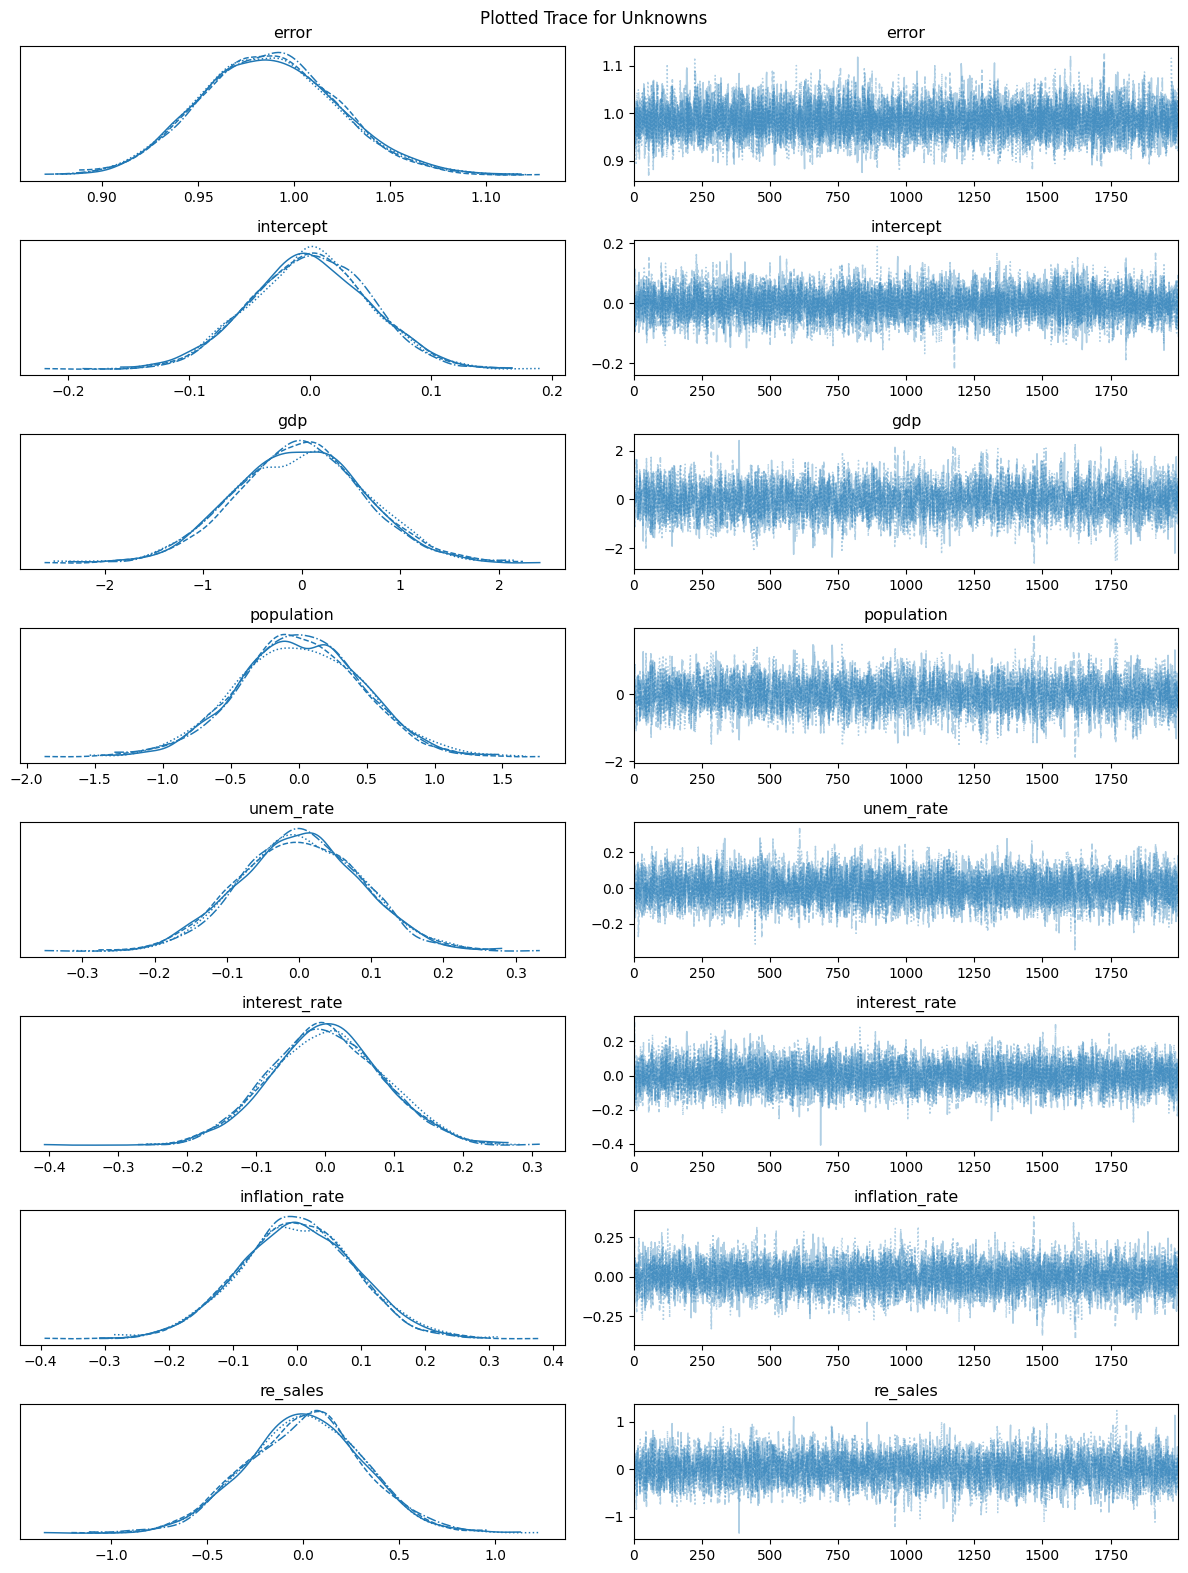

In [179]:
ax = pm.plot_trace(simulated_trace)
ax[0][0].get_figure().suptitle('Plotted Trace for Unknowns')
plt.tight_layout()
plt.show()

In [181]:
# simulate our next output
with simulated_model:
    n_data = {
        'gdp_o' : x_test['gdp'],
        'population_o' : x_test['population'],
        'unem_rate_o' : x_test['unemployment_rate'],
        'interest_rate_o' : x_test['interest_rate'],
        'inflation_rate_o' : x_test['inflation_rate'],
        're_sales_o' : x_test['real_estate_sales']
         
    }

    pm.set_data(n_data)
    posterior = pm.sample_posterior_predictive(simulated_trace)

TypeError: The variable `gdp_o` must be a `SharedVariable` (created through `pm.MutableData()` or `pm.Data(mutable=True)`) to allow updating. The current type is: <class 'pytensor.tensor.var.TensorConstant'>